In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr

# Загрузка и предобработка данных

In [2]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
mcap = pd.read_csv("factors/russia/mcap.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
volume = prices * volume  # convert volume from lots to money

prices, mcap, volume = pqr.utils.replace_with_nan(prices, mcap, volume)

# Настраиваем окружение - Юниверс, Бенчмарк и дашборд с инфой по портфелю

In [3]:
universe = volume >= 100_000
returns_calculator = pqr.utils.partial(pqr.calculate_returns, universe_returns=pqr.prices_to_returns(prices))

benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [4]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)

fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    kwargs={
        "figsize": (10, 6),
    }
)

summary = pqr.metrics.Dashboard([table, fig])

# 1 способ использования: строим факторную модель

In [5]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_mean, period=3),
    pqr.utils.partial(pqr.factors.hold, period=3),
)
size = mean_transform(mcap)

portfolios = pqr.factors.backtest_factor_portfolios(
    factor=size,
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=True,
)

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.46*** (2.42),1.36*** (2.60),1.28*** (2.75),0.18 (0.45)
"Monthly Volatility, %",8.97,7.73,6.94,5.79
"Maximum Drawdown, %",-74.62,-68.69,-67.79,-60.16
"Monthly Mean Excess Return, %",0.21 (0.84),0.10 (0.45),0.03 (0.13),-1.08 (-2.11)
"Monthly Alpha, %",0.07 (0.29),0.18 (0.78),0.25 (1.12),-0.18 (-0.48)
"Monthly Beta, %",1.11*** (34.15),0.94*** (30.94),0.83*** (27.99),0.28*** (5.74)


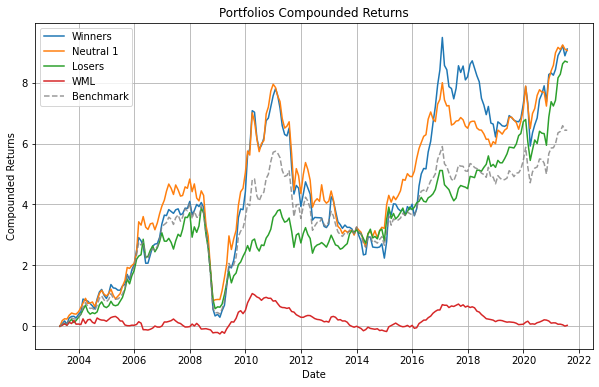

In [6]:
summary.display(portfolios)

## Поищем модель получше

In [7]:
def mean_transform_factory(looking, lag, holding):
    return pqr.utils.compose(
        pqr.utils.partial(pqr.factors.filter, universe=universe),
        pqr.utils.partial(pqr.factors.look_back_mean, period=looking),
        pqr.utils.partial(pqr.factors.lag, period=lag),
        pqr.utils.partial(pqr.factors.hold, period=holding),
    )


transforms_grid = {
    "(1, 0, 1)": mean_transform_factory(1, 0, 1),
    "(1, 1, 1)": mean_transform_factory(1, 1, 1),
    "(3, 0, 3)": mean_transform_factory(3, 0, 3),
    "(3, 1, 3)": mean_transform_factory(3, 1, 3),
    "(6, 0, 6)": mean_transform_factory(6, 0, 6),
    "(6, 1, 6)": mean_transform_factory(6, 1, 6),
    "(9, 0, 9)": mean_transform_factory(9, 0, 9),
    "(9, 1, 9)": mean_transform_factory(9, 1, 9),
    "(12, 0, 12)": mean_transform_factory(12, 0, 12),
    "(12, 1, 12)": mean_transform_factory(12, 1, 12),
}

results = pqr.factors.grid_search_factor_portfolios(
    factor=mcap,
    transforms=transforms_grid,
    metric=pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
    ),
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=True,
)

In [8]:
results.round(3)

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",-0.030,0.044,0.034,-0.064
"(1, 1, 1)",-0.031,0.034,0.035,-0.066
"(3, 0, 3)",0.008,0.021,0.030,-0.021
"(3, 1, 3)",-0.002,0.017,0.032,-0.034
"(6, 0, 6)",0.014,0.004,0.048,-0.034
"(6, 1, 6)",0.011,-0.002,0.041,-0.030
"(9, 0, 9)",0.021,0.037,0.062,-0.042
"(9, 1, 9)",0.021,0.047,0.056,-0.034
"(12, 0, 12)",0.017,0.054,0.035,-0.018
"(12, 1, 12)",0.011,0.065,0.029,-0.018


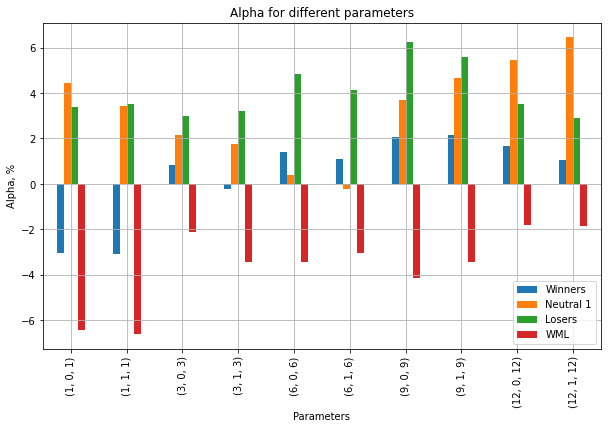

In [9]:
(results * 100).plot.bar(figsize=(10, 6))
plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha, %")
plt.grid();

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.31** (2.27),1.38*** (2.77),1.42*** (2.91),-0.11 (-0.29)
"Monthly Volatility, %",8.42,7.25,7.13,5.67
"Maximum Drawdown, %",-76.27,-64.86,-63.91,-63.55
"Monthly Mean Excess Return, %",0.18 (0.67),0.25 (1.08),0.29 (1.22),-1.24 (-2.16)
"Monthly Alpha, %",0.18 (0.65),0.39* (1.74),0.46** (2.00),-0.29 (-0.74)
"Monthly Beta, %",1.00*** (27.48),0.87*** (29.39),0.85*** (27.43),0.15*** (2.99)


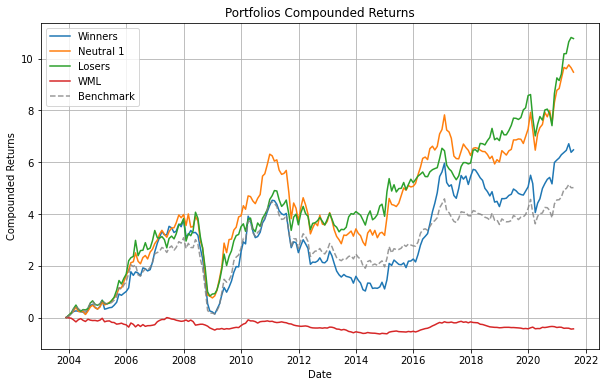

In [10]:
best_portfolios = pqr.factors.backtest_factor_portfolios(
    factor=mean_transform_factory(9, 1, 9)(mcap),
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=True,
)

summary.display(best_portfolios)

### Лучший портфель поподробнее

In [11]:
best_portfolio = best_portfolios[0]

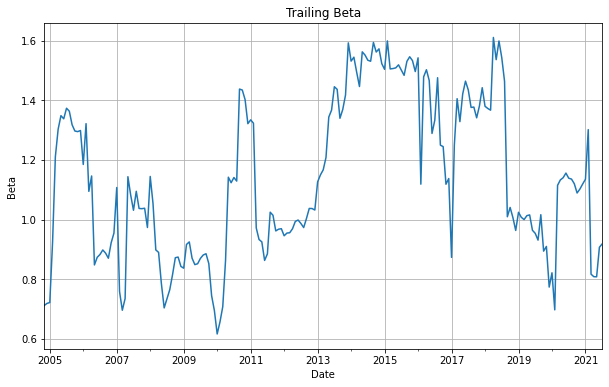

In [12]:
pqr.metrics.trailing_beta(best_portfolio, benchmark).plot(figsize=(10, 6))

plt.title("Trailing Beta")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.grid();

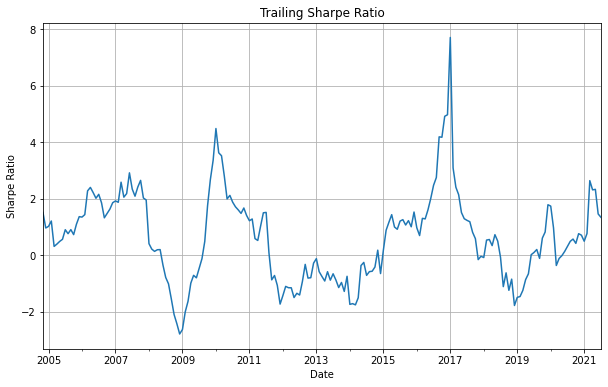

In [13]:
pqr.metrics.trailing_sharpe_ratio(best_portfolio).plot(figsize=(10, 6))

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

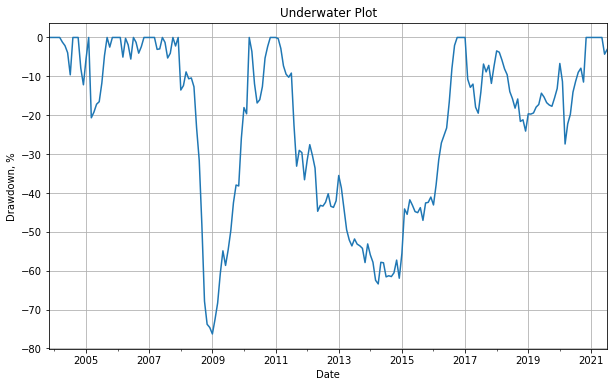

In [14]:
(pqr.metrics.drawdown(best_portfolio) * 100).plot(figsize=(10, 6))

plt.title("Underwater Plot")
plt.xlabel("Date")
plt.ylabel("Drawdown, %")
plt.grid();

# 2 способ использования: строим и настраиваем портфель

,Top 10,Top 10%
"Monthly Mean Return, %",1.32*** (2.81),1.45*** (2.85)
"Monthly Volatility, %",6.95,7.53
"Maximum Drawdown, %",-66.89,-67.33
"Monthly Mean Excess Return, %",0.06 (0.26),0.19 (0.61)
"Monthly Alpha, %",0.28 (1.26),0.42 (1.37)
"Monthly Beta, %",0.82*** (27.65),0.82*** (20.29)


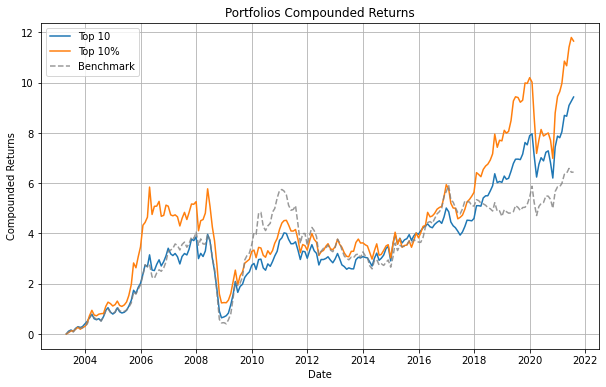

In [15]:
# создадим 2 стратегии отбора акций: топ-10 акций по фактору и топ 10% акций по фактору
# и проинвестируем в оба в нашу изначальную стратегию 3-0-3

top10_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.top(size, 10),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Top 10",
)

q01_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(size, 0.9, 1),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Top 10%",
)

summary.display([top10_portfolio, q01_portfolio])

,Top 10,Top 10 Smart Beta
"Monthly Mean Return, %",1.32*** (2.81),1.33*** (2.74)
"Monthly Volatility, %",6.95,7.20
"Maximum Drawdown, %",-66.89,-67.01
"Monthly Mean Excess Return, %",0.06 (0.26),0.07 (0.27)
"Monthly Alpha, %",0.28 (1.26),0.31 (1.15)
"Monthly Beta, %",0.82*** (27.65),0.82*** (22.94)


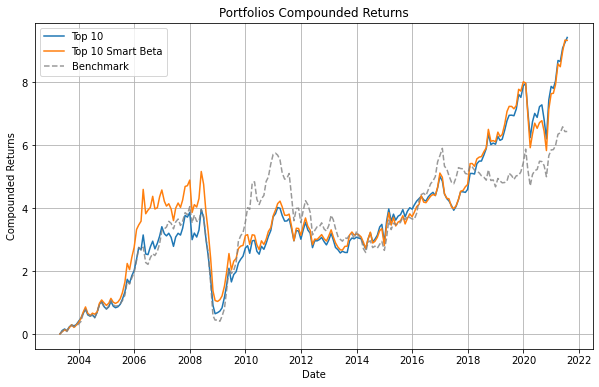

In [16]:
top10_portfolio_smart_beta = pqr.Portfolio.backtest(
    longs=pqr.factors.top(size, 10),
    shorts=None,
    allocator=pqr.utils.partial(
        pqr.normalized_weights,
        base_weights=size,
    ),
    calculator=returns_calculator,
    name="Top 10 Smart Beta",
)

summary.display([top10_portfolio, top10_portfolio_smart_beta])

,Top 10,Top 10 Smart Beta,Top 10 Smart Beta Reversed
"Monthly Mean Return, %",1.32*** (2.81),1.33*** (2.74),1.30*** (2.70)
"Monthly Volatility, %",6.95,7.20,7.16
"Maximum Drawdown, %",-66.89,-67.01,-68.01
"Monthly Mean Excess Return, %",0.06 (0.26),0.07 (0.27),0.05 (0.19)
"Monthly Alpha, %",0.28 (1.26),0.31 (1.15),0.26 (1.05)
"Monthly Beta, %",0.82*** (27.65),0.82*** (22.94),0.83*** (24.88)


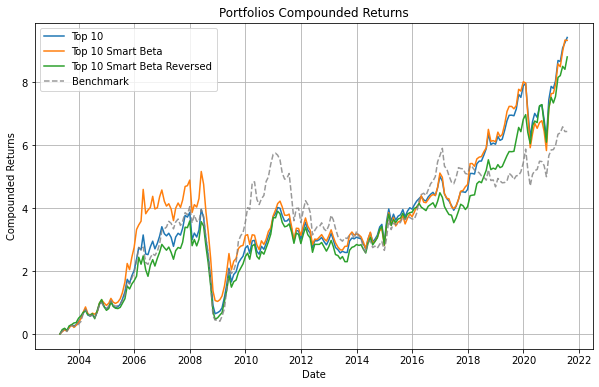

In [17]:
top10_portfolio_smart_beta_reversed = pqr.Portfolio.backtest(
    longs=pqr.factors.top(size, 10),
    shorts=None,
    allocator=pqr.utils.partial(
        pqr.normalized_weights,
        base_weights=1 / size,
    ),
    calculator=returns_calculator,
    name="Top 10 Smart Beta Reversed",
)

summary.display([
    top10_portfolio,
    top10_portfolio_smart_beta,
    top10_portfolio_smart_beta_reversed
])

# Случайный тест

In [18]:
%%time
%%capture

monkey_est = pqr.tests.monkey_test(
    best_portfolio,
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    n=1000,
)

CPU times: user 19.1 s, sys: 655 ms, total: 19.8 s
Wall time: 19.8 s


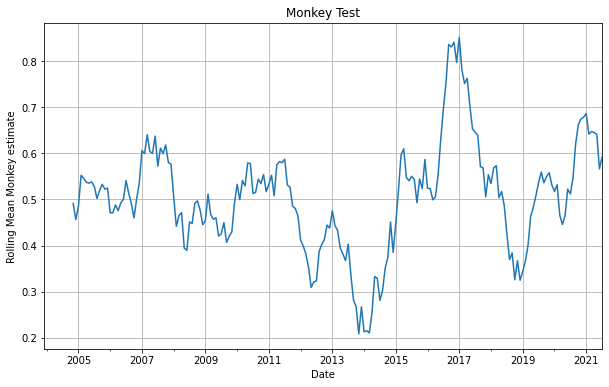

In [19]:
monkey_est.rolling(12).mean().plot(figsize=(10, 6))

plt.title("Monkey Test")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Monkey estimate")
plt.grid();